# Analyse the different train/test period experiments

In [138]:
# !pip install netcdf4

In [139]:
# !conda install -c conda-forge shap==0.30

In [140]:
# !conda update matplotlib

In [13]:
from pathlib import Path
import os
import warnings
from typing import Tuple, Optional, Union, Dict, List

%load_ext autoreload
%autoreload

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/jovyan/ml_drought


In [3]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

data_dir = Path('data/')

assert data_dir.exists()

In [4]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.utils import get_ds_mask

# Get all experiment files

In [86]:
features = [d for d in (data_dir / 'features/').glob('2020*TR*')]
features.sort()
models = [d for d in (data_dir / 'models/').glob('2020*TR*')]
models.sort()

print(f"No. Driving Data:  {len(features)}")
print(f"No. Modelled Data: {len(models)}")

print(features[0])
print(models[0])

No. Driving Data:  27
No. Modelled Data: 27
data/features/2020_02_18:161206_one_month_forecast_TRhigh_TEhigh_LEN51
data/models/2020_02_18:161206_one_month_forecast_TRhigh_TEhigh_LEN51


In [102]:
# get parameters for experiments
test_length = 12
pred_timesteps = 3

train_hilos = [m.name.split('_')[-3][2:] for m in models]
test_hilos = [m.name.split('_')[-2][2:] for m in models]
train_lengths = [int(m.name.split('_')[-1][3:]) for m in models]

In [110]:
from pandas.tseries.offsets import MonthEnd

# GET TEST TIMES
test_times = [
    np.array([
        pd.to_datetime('-'.join(d.name.split('preds_')[-1].replace('.nc', '').split('_'))) + MonthEnd(1)
        for d in (model / 'ealstm').glob('*.nc')
    ])
    for model in models
]

test_times2 = [
    np.array([
        pd.to_datetime('-'.join(d.name.split('_'))) + MonthEnd(1)
        for d in (feature / 'test').iterdir()
    ])
    for feature in features
]

# GET TRAIN TIMES
train_times = [
    np.array([
        pd.to_datetime('-'.join(d.name.split('_'))) + MonthEnd(1)
        for d in (feature / 'train').iterdir()
    ])
    for feature in features
]

# check no. test timesteps is 
assert all([test_length == len(tt) for tt in test_times2])

# check no. train timesteps are equivalent
assert all([np.isclose(train_lengths[i], len(train_times[i]), atol=15) for i in range(len(train_times))])

print(train_lengths)
print([len(train_times[i]) for i in range(len(train_times))])

# TODO: why is the number of model preds.nc objects different?
print([len(test_times[i]) for i in range(len(test_times))])

[51, 102, 153, 51, 102, 153, 51, 102, 153, 51, 102, 153, 51, 102, 153, 51, 102, 153, 51, 102, 153, 51, 102, 153, 51, 102, 153]
[51, 114, 154, 51, 114, 154, 51, 113, 153, 51, 114, 153, 51, 113, 154, 51, 110, 154, 51, 115, 155, 51, 112, 153, 51, 114, 156]
[23, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 10, 12, 12, 12, 12, 12, 12, 12, 12, 10, 12]


## Rebuild experiment objects

In [114]:
from scripts.experiments.experiment import Experiment

In [121]:
sorted_timesteps = pd.date_range('2008-01-01', '2020-01-01', freq='M')
all_experiments = []
for (
    train_hilo, test_hilo, test_length, train_timesteps, test_timesteps
) in zip(train_hilos, test_hilos, test_lengths, train_times, test_times2):
    e = Experiment(
        train_length=12,
        train_hilo=train_hilo,
        test_hilo=test_hilo,
        test_length=test_length,
        sorted_timesteps=sorted_timesteps,
        pred_timesteps = 3,
    )
    e.train_timesteps = train_timesteps
    e.test_timesteps = test_timesteps
    
    all_experiments.append(e)

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_calculate_hilo_dict', 'get_experiment_timesteps', 'get_test_timesteps_plus', 'plot_experiment_split', 'pred_timesteps', 'print_experiment_summary', 'replacement', 'reshuffle', 'sorted_timesteps', 'test_hilo', 'test_length', 'test_timesteps', 'train_hilo', 'train_length', 'train_timesteps']


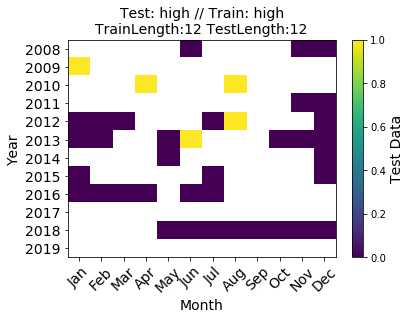

In [126]:
print(dir(all_experiments[0]))

all_experiments[0].plot_experiment_split()

# Load in the data

In [135]:
# Experiment names
experiments = [d.name for d in models]
true_data_experiments = [d.name for d in features]

TARGET_VAR = 'boku_VCI'

# check the experiments are aligned properly
assert all(
    [
        '_'.join(experiments[i].split('_')[3:]) == '_'.join(true_data_experiments[i].split('_')[3:])
        for i in range(len(experiments))
    ]
)

In [133]:
print('_'.join(experiments[0].split('_')[3:]))
print('_'.join(true_data_experiments[0].split('_')[3:]))

one_month_forecast_TRhigh_TEhigh_LEN51
one_month_forecast_TRhigh_TEhigh_LEN51


In [ ]:
obs_dict = {}
model_dict = {}

for TRUE_EXPERIMENT, EXPERIMENT in zip(true_data_experiments, experiments):
    expt_name = '_'.join(EXPERIMENT.split('_')[3:])
    
    X_train, y_train = read_train_data(data_dir, experiment=TRUE_EXPERIMENT)
    X_test, y_test = read_test_data(data_dir, experiment=TRUE_EXPERIMENT)
    

for EXPERIMENT, experiment_name in zip(experiments, experiment_names):
    model_dict[experiment_name] = {}
    lstm_pred = read_pred_data('rnn', data_dir, experiment=EXPERIMENT)[-1].where(~mask)
    model_dict[experiment_name]['lstm_pred'] = lstm_pred
    
    # did we run persistence?
    if bline:
        bline_pred = read_pred_data('previous_month', data_dir, experiment=EXPERIMENT)[-1].where(~mask)
        model_dict[experiment_name]['bline_pred'] = bline_pred
    
    # did we run ealstm?
    if 'static' in experiment_name: 
        ealstm_pred = read_pred_data('ealstm', data_dir, experiment=EXPERIMENT)[-1].where(~mask)
        model_dict[experiment_name]['ealstm_pred'] = ealstm_pred